In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import warnings
import datetime
from lightgbm import LGBMRegressor
from chinese_calendar import is_workday
import joblib
warnings.filterwarnings("ignore")

## 思路

我们还是和第二问题解(LGBM)加入19-01月数据预测19-02（日期4.7）一样的，先将预测出来的2月数据进行合并，再去构造19-3月的数据

然后预测出3月的数据

# 读取数据并合并

In [2]:
#读取经过处理的原本数据：
pd.options.display.max_columns=100 # to see columns 
df1 = pd.read_csv('data/proess_transform1.csv',encoding='utf-8')
df1

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1
811935,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1
811936,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1
811937,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1


In [3]:
# 读取预测出的构造的19-02月的数据：

df2 = pd.read_csv('output/构造的2月数据预测结果.csv',encoding='utf-8')
df2

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2019-02-01,102,20921,302,408,0,7.0,2019,2,1,0,0,1250,1,0,3,4,1
1,2019-02-01,101,21601,306,407,0,3.0,2019,2,1,0,0,1250,1,0,3,4,1
2,2019-02-01,102,20591,302,408,0,4.0,2019,2,1,0,0,1250,0,0,3,4,1
3,2019-02-01,101,21573,306,407,1,8.0,2019,2,1,0,0,1250,1,0,3,4,1
4,2019-02-01,105,21342,302,408,0,7.0,2019,2,1,0,0,1250,2,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,6.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28,105,20046,303,401,0,7.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28,101,20820,306,407,1,38.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28,101,21770,302,408,1,7.0,2019,2,28,0,0,1277,1,2,3,3,1


In [4]:
#拼接合并数据作为训练集：

df =pd.concat([df1,df2],axis=0)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,6.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28,105,20046,303,401,0,7.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28,101,20820,306,407,1,38.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28,101,21770,302,408,1,7.0,2019,2,28,0,0,1277,1,2,3,3,1


# 构造19年03月的数据：

In [5]:
temp = df[df['销售区域编码']!=104]
temp #减少了2w多数据 25053


,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
8,2015-09-02,102,20323,305,412,0,502.0,2015,9,2,0,0,2,0,0,2,2,1
9,2015-09-02,102,21350,305,412,0,107.0,2015,9,2,0,0,2,0,0,2,2,1
10,2015-09-02,101,20657,303,410,0,18.0,2015,9,2,0,0,2,6,0,2,2,1
11,2015-09-02,102,20457,305,412,0,308.0,2015,9,2,0,0,2,0,0,2,2,1
12,2015-09-03,102,21052,303,401,0,14.0,2015,9,3,1,0,3,5,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,6.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28,105,20046,303,401,0,7.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28,101,20820,306,407,1,38.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28,101,21770,302,408,1,7.0,2019,2,28,0,0,1277,1,2,3,3,1


In [6]:
# 构造19年03月的数据：
temp['zuhe'] = temp['销售区域编码'].astype(str)+'_'+temp['产品大类编码'].astype(str)+'_'+temp['产品细类编码'].astype(str)+'_'+temp['产品编码'].astype(str)
temp

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,zuhe
8,2015-09-02,102,20323,305,412,0,502.0,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20323
9,2015-09-02,102,21350,305,412,0,107.0,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_21350
10,2015-09-02,101,20657,303,410,0,18.0,2015,9,2,0,0,2,6,0,2,2,1,101_303_410_20657
11,2015-09-02,102,20457,305,412,0,308.0,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20457
12,2015-09-03,102,21052,303,401,0,14.0,2015,9,3,1,0,3,5,0,2,3,0,102_303_401_21052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,6.0,2019,2,28,0,0,1277,2,2,3,3,1,101_306_407_20312
143048,2019-02-28,105,20046,303,401,0,7.0,2019,2,28,0,0,1277,5,2,3,3,1,105_303_401_20046
143049,2019-02-28,101,20820,306,407,1,38.0,2019,2,28,0,0,1277,3,2,3,3,1,101_306_407_20820
143050,2019-02-28,101,21770,302,408,1,7.0,2019,2,28,0,0,1277,1,2,3,3,1,101_302_408_21770


In [7]:
#从2019-3-1到2019-3-31日的数据

dt1 = pd.date_range(start="20190301", end="20190331", freq="D")
dt1
len(dt1)
dates=[]
need=[]
ids =[]
for d in dt1:
    date = str(d).split(' ')[0] #得到日期xx-xx-xx
    dates=dates+[date]*len(set(temp['zuhe']))
    need = need+[0]*len(set(temp['zuhe']))
    ids=ids+list(set(temp['zuhe']))

In [8]:
tempdf=pd.DataFrame()
tempdf['订单日期']=dates
tempdf['zuhe']=ids
tempdf['订单需求量']=need
tempdf

,订单日期,zuhe,订单需求量
0,2019-03-01,101_305_412_20020,0
1,2019-03-01,101_302_408_20070,0
2,2019-03-01,105_306_407_20495,0
3,2019-03-01,101_306_407_20473,0
4,2019-03-01,105_306_407_20116,0
...,...,...,...
158374,2019-03-31,105_306_407_21424,0
158375,2019-03-31,102_306_407_21151,0
158376,2019-03-31,105_303_401_21070,0
158377,2019-03-31,101_305_412_22032,0


In [9]:
## chu处理tempdf为df的数据格式：

tempdf['销售区域编码']=tempdf['zuhe'].str.split('_',expand=True)[0]
tempdf['产品大类编码']=tempdf['zuhe'].str.split('_',expand=True)[1]
tempdf['产品细类编码']=tempdf['zuhe'].str.split('_',expand=True)[2]
tempdf['产品编码']=tempdf['zuhe'].str.split('_',expand=True)[3]
tempdf
import chinese_calendar
import datetime

tempdf['订单日期'] = pd.to_datetime(tempdf['订单日期'])  #对日期列进行日期格式转换
tempdf['Year'] = tempdf.订单日期.dt.year #分解出年份
tempdf['Month'] = tempdf.订单日期.dt.month
tempdf['day'] = tempdf.订单日期.dt.day

tempdf

import datetime
from chinese_calendar import is_holiday, is_workday
is_holidays =[]  #用来存放日期是否为节假日。1为是，0为不是
for index,row in tempdf.iterrows():
    day = datetime.date(int(row['Year']), int(row['Month']),int(row['day']))
    if is_holiday(day):
        is_holidays.append(1)
    else:
        is_holidays.append(0)
tempdf['是否节假日'] = is_holidays  #加入到表格汇总
tempdf


,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日
0,2019-03-01,101_305_412_20020,0,101,305,412,20020,2019,3,1,0
1,2019-03-01,101_302_408_20070,0,101,302,408,20070,2019,3,1,0
2,2019-03-01,105_306_407_20495,0,105,306,407,20495,2019,3,1,0
3,2019-03-01,101_306_407_20473,0,101,306,407,20473,2019,3,1,0
4,2019-03-01,105_306_407_20116,0,105,306,407,20116,2019,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,105_306_407_21424,0,105,306,407,21424,2019,3,31,1
158375,2019-03-31,102_306_407_21151,0,102,306,407,21151,2019,3,31,1
158376,2019-03-31,105_303_401_21070,0,105,303,401,21070,2019,3,31,1
158377,2019-03-31,101_305_412_22032,0,101,305,412,22032,2019,3,31,1


In [10]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']
cuxs=[]

#再得到日期是否是自己自定义的促销日：
for index ,row in tempdf.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


tempdf['是否促销日']=cuxs
tempdf

,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日
0,2019-03-01,101_305_412_20020,0,101,305,412,20020,2019,3,1,0,1
1,2019-03-01,101_302_408_20070,0,101,302,408,20070,2019,3,1,0,1
2,2019-03-01,105_306_407_20495,0,105,306,407,20495,2019,3,1,0,1
3,2019-03-01,101_306_407_20473,0,101,306,407,20473,2019,3,1,0,1
4,2019-03-01,105_306_407_20116,0,105,306,407,20116,2019,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,105_306_407_21424,0,105,306,407,21424,2019,3,31,1,0
158375,2019-03-31,102_306_407_21151,0,102,306,407,21151,2019,3,31,1,0
158376,2019-03-31,105_303_401_21070,0,105,303,401,21070,2019,3,31,1,0
158377,2019-03-31,101_305_412_22032,0,101,305,412,22032,2019,3,31,1,0


In [11]:
jagdf=temp[['zuhe','价格区间','销售渠道名称']]
jagdf.drop_duplicates(['zuhe'],keep='last',inplace=True)
jagdf
dict_jg = {}
qudao_dict={}
for i in range(len(jagdf)):
    dict_jg[list(jagdf['zuhe'])[i]]=list(jagdf['价格区间'])[i]
    qudao_dict[list(jagdf['zuhe'])[i]] = list(jagdf['销售渠道名称'])[i]
dict_jg
qudao_dict
#价格区间：
jiage=[]
qudao =[]
for v in tempdf['zuhe']:
    jiage.append(dict_jg[v])
    qudao.append(qudao_dict[v])
tempdf['价格区间']=jiage
tempdf['销售渠道名称']=qudao
tempdf


,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称
0,2019-03-01,101_305_412_20020,0,101,305,412,20020,2019,3,1,0,1,6,0
1,2019-03-01,101_302_408_20070,0,101,302,408,20070,2019,3,1,0,1,5,0
2,2019-03-01,105_306_407_20495,0,105,306,407,20495,2019,3,1,0,1,3,0
3,2019-03-01,101_306_407_20473,0,101,306,407,20473,2019,3,1,0,1,4,1
4,2019-03-01,105_306_407_20116,0,105,306,407,20116,2019,3,1,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,105_306_407_21424,0,105,306,407,21424,2019,3,31,1,0,1,0
158375,2019-03-31,102_306_407_21151,0,102,306,407,21151,2019,3,31,1,0,2,0
158376,2019-03-31,105_303_401_21070,0,105,303,401,21070,2019,3,31,1,0,4,1
158377,2019-03-31,101_305_412_22032,0,101,305,412,22032,2019,3,31,1,0,0,0


In [12]:
tempdf['标签'] = "空"


for index,row in tempdf.iterrows():
    ts = pd.Timestamp(row['Year'],row['Month'],row['day'])
    end=ts+pd.offsets.MonthEnd()
    if row['订单日期'] < pd.to_datetime(end) and row['订单日期'] <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],10)):
        tempdf.at[index,'标签'] = "月初"
    elif pd.to_datetime(pd.Timestamp(row['Year'], row['Month'],10))< row['订单日期']  <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],20)):
        tempdf.at[index,'标签'] = "月中" 
    else:
        tempdf.at[index,'标签'] = "月末" 
                        
tempdf
tempdf["season"] = tempdf["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
tempdf['season_bm'] =tempdf.season.map(dict_season)
tempdf
dict_moth = {'月初':0,'月中':1,'月末':2}
tempdf['每月时间段'] =tempdf.标签.map(dict_moth)
tempdf

,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签,season,season_bm,每月时间段
0,2019-03-01,101_305_412_20020,0,101,305,412,20020,2019,3,1,0,1,6,0,月初,春季,0,0
1,2019-03-01,101_302_408_20070,0,101,302,408,20070,2019,3,1,0,1,5,0,月初,春季,0,0
2,2019-03-01,105_306_407_20495,0,105,306,407,20495,2019,3,1,0,1,3,0,月初,春季,0,0
3,2019-03-01,101_306_407_20473,0,101,306,407,20473,2019,3,1,0,1,4,1,月初,春季,0,0
4,2019-03-01,105_306_407_20116,0,105,306,407,20116,2019,3,1,0,1,2,0,月初,春季,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,105_306_407_21424,0,105,306,407,21424,2019,3,31,1,0,1,0,月末,春季,0,2
158375,2019-03-31,102_306_407_21151,0,102,306,407,21151,2019,3,31,1,0,2,0,月末,春季,0,2
158376,2019-03-31,105_303_401_21070,0,105,303,401,21070,2019,3,31,1,0,4,1,月末,春季,0,2
158377,2019-03-31,101_305_412_22032,0,101,305,412,22032,2019,3,31,1,0,0,0,月末,春季,0,2


In [13]:
tempdf['星期几'] = tempdf.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}

tempdf['is_workday']=tempdf['订单日期'].map(lambda x:is_workday(x))

dict_is_workday = {False:0,True:1}
tempdf['is_workday'] =tempdf.is_workday.map(dict_is_workday)
tempdf
tempdf.drop(['标签','season','zuhe'],axis=1,inplace=True)
tempdf

,订单日期,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,season_bm,每月时间段,星期几,is_workday
0,2019-03-01,0,101,305,412,20020,2019,3,1,0,1,6,0,0,0,4,1
1,2019-03-01,0,101,302,408,20070,2019,3,1,0,1,5,0,0,0,4,1
2,2019-03-01,0,105,306,407,20495,2019,3,1,0,1,3,0,0,0,4,1
3,2019-03-01,0,101,306,407,20473,2019,3,1,0,1,4,1,0,0,4,1
4,2019-03-01,0,105,306,407,20116,2019,3,1,0,1,2,0,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,0,105,306,407,21424,2019,3,31,1,0,1,0,0,2,6,0
158375,2019-03-31,0,102,306,407,21151,2019,3,31,1,0,2,0,0,2,6,0
158376,2019-03-31,0,105,303,401,21070,2019,3,31,1,0,4,1,0,2,6,0
158377,2019-03-31,0,101,305,412,22032,2019,3,31,1,0,0,0,0,2,6,0


In [14]:
dt1 = pd.date_range(start="20150901", end="20190331", freq="D")  #
dt1
dicts = {}
i =1
for date in dt1:
#     print(str(date).split(' ')[0])
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
Ds=[]
for dat in tempdf['订单日期']:
#     print(dicts[str(dat).split(' ')[0]])
    Ds.append(dicts[str(dat).split(' ')[0]])
tempdf['D'] = Ds
tempdf
df_sub=tempdf[['订单日期', '销售区域编码', '产品编码', '产品大类编码', '产品细类编码', '销售渠道名称', '订单需求量', 'Year',
       'Month', 'day', '是否节假日', '是否促销日', 'D', '价格区间', '每月时间段', 'season_bm',
       '星期几', 'is_workday',]]
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2019-03-01,101,20020,305,412,0,0,2019,3,1,0,1,1278,6,0,0,4,1
1,2019-03-01,101,20070,302,408,0,0,2019,3,1,0,1,1278,5,0,0,4,1
2,2019-03-01,105,20495,306,407,0,0,2019,3,1,0,1,1278,3,0,0,4,1
3,2019-03-01,101,20473,306,407,1,0,2019,3,1,0,1,1278,4,0,0,4,1
4,2019-03-01,105,20116,306,407,0,0,2019,3,1,0,1,1278,2,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,105,21424,306,407,0,0,2019,3,31,1,0,1308,1,2,0,6,0
158375,2019-03-31,102,21151,306,407,0,0,2019,3,31,1,0,1308,2,2,0,6,0
158376,2019-03-31,105,21070,303,401,1,0,2019,3,31,1,0,1308,4,2,0,6,0
158377,2019-03-31,101,22032,305,412,0,0,2019,3,31,1,0,1308,0,2,0,6,0


In [15]:
df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]] = df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]].apply(pd.to_numeric)
df_sub['价格区间']=df_sub['价格区间'].astype('category')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158379 entries, 0 to 158378
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        158379 non-null  datetime64[ns]
 1   销售区域编码      158379 non-null  int64         
 2   产品编码        158379 non-null  int64         
 3   产品大类编码      158379 non-null  int64         
 4   产品细类编码      158379 non-null  int64         
 5   销售渠道名称      158379 non-null  int64         
 6   订单需求量       158379 non-null  int64         
 7   Year        158379 non-null  int64         
 8   Month       158379 non-null  int64         
 9   day         158379 non-null  int64         
 10  是否节假日       158379 non-null  int64         
 11  是否促销日       158379 non-null  int64         
 12  D           158379 non-null  int64         
 13  价格区间        158379 non-null  category      
 14  每月时间段       158379 non-null  int64         
 15  season_bm   158379 non-null  int64         
 16  星期

In [16]:
# b保存一下构造的19年3月数据：
df_sub.to_csv('data/构造19_03data.csv',index=False,)

In [17]:
df 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143047,2019-02-28,101,20312,306,407,0,6.0,2019,2,28,0,0,1277,2,2,3,3,1
143048,2019-02-28,105,20046,303,401,0,7.0,2019,2,28,0,0,1277,5,2,3,3,1
143049,2019-02-28,101,20820,306,407,1,38.0,2019,2,28,0,0,1277,3,2,3,3,1
143050,2019-02-28,101,21770,302,408,1,7.0,2019,2,28,0,0,1277,1,2,3,3,1


In [18]:
df1 =pd.concat([df,df_sub],axis=0)
df1.reset_index(drop=True)
df1 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31 00:00:00,105,21424,306,407,0,0.0,2019,3,31,1,0,1308,1,2,0,6,0
158375,2019-03-31 00:00:00,102,21151,306,407,0,0.0,2019,3,31,1,0,1308,2,2,0,6,0
158376,2019-03-31 00:00:00,105,21070,303,401,1,0.0,2019,3,31,1,0,1308,4,2,0,6,0
158377,2019-03-31 00:00:00,101,22032,305,412,0,0.0,2019,3,31,1,0,1308,0,2,0,6,0


In [19]:
df = df1 
del df1 
df 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31 00:00:00,105,21424,306,407,0,0.0,2019,3,31,1,0,1308,1,2,0,6,0
158375,2019-03-31 00:00:00,102,21151,306,407,0,0.0,2019,3,31,1,0,1308,2,2,0,6,0
158376,2019-03-31 00:00:00,105,21070,303,401,1,0.0,2019,3,31,1,0,1308,4,2,0,6,0
158377,2019-03-31 00:00:00,101,22032,305,412,0,0.0,2019,3,31,1,0,1308,0,2,0,6,0


# 特征工程

## 滞后特征

In [20]:
#Introduce lags
lags = [1,2,3,6,12,24,36,48,60]
for lag in lags:
    df['need_lag_'+str(lag)] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码',],as_index=False)['订单需求量'].shift(lag).astype(np.float16)

## 均值编码

In [21]:
df['产品编码_avg'] = df.groupby('产品编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_need_avg'] = df.groupby('销售区域编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_need_avg'] = df.groupby('产品大类编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_need_avg'] = df.groupby('产品细类编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_need_avg'] = df.groupby('销售渠道名称')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品编码_need_avg'] = df.groupby(['产品编码','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品编码_need_avg'] = df.groupby(['产品大类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_产品编码_need_avg'] = df.groupby(['产品细类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品编码_need_avg'] = df.groupby(['销售渠道名称','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品大类编码_need_avg'] = df.groupby(['销售区域编码','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品细类编码_need_avg'] = df.groupby(['产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品细类编码_need_avg'] = df.groupby(['销售渠道名称','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)

df['年_月_need_avg'] = df.groupby(['Year','Month'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售区域编码_need_avg'] = df.groupby(['Year','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品大类编码_need_avg'] = df.groupby(['Year','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品细类编码_need_avg'] = df.groupby(['Year','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售渠道名称_need_avg'] = df.groupby(['Year','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['月_销售区域编码_need_avg'] = df.groupby(['Month','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品大类编码_need_avg'] = df.groupby(['Month','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品细类编码_need_avg'] = df.groupby(['Month','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_销售渠道名称_need_avg'] = df.groupby(['Month','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)

df['每月时间段_销售区域编码_need_avg'] = df.groupby(['销售区域编码','每月时间段'])['订单需求量'].transform('mean').astype(np.float16)

df['价格区间_销售区域编码_need_avg'] = df.groupby(['销售区域编码','价格区间'])['订单需求量'].transform('mean').astype(np.float16)

## 滑动窗口统计

In [22]:
df['rolling_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

## 开窗数据拓展

In [23]:
df['expanding_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

## 需求趋势构建

In [24]:
df['daily_avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码','D'])['订单需求量'].transform('mean').astype(np.float16)
df['avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['need_trend'] = (df['daily_avg_need'] - df['avg_need']).astype(np.float16)
df.drop(['daily_avg_need','avg_need'],axis=1,inplace=True)

In [25]:
df.drop('订单日期',axis=1,inplace=True)
df

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,104,22069,307,403,0,19.0,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.56250,63.84375,63.84375,46.40625,12.289062,12.289062,12.289062,12.664062,102.87500,63.84375,57.03125,107.6875,111.062500,116.625000,116.625000,106.000000,103.750000,110.750000,110.750000,73.875000,92.62500,61.28125,NaN,NaN,6.710938
1,104,20028,301,405,0,12.0,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.933594,94.56250,52.59375,52.59375,46.40625,9.000000,4.933594,4.933594,4.933594,86.81250,52.59375,29.68750,107.6875,111.062500,84.437500,84.437500,106.000000,103.750000,70.437500,70.437500,73.875000,92.62500,61.28125,NaN,NaN,3.000000
2,104,21183,307,403,1,109.0,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.937500,94.56250,63.84375,63.84375,66.06250,130.125000,106.937500,106.937500,129.750000,102.87500,63.84375,77.56250,107.6875,111.062500,116.625000,116.625000,153.250000,103.750000,110.750000,110.750000,123.875000,92.62500,120.18750,NaN,NaN,-21.125000
3,104,20448,308,404,1,3.0,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.437500,94.56250,68.68750,68.68750,66.06250,100.500000,59.437500,59.437500,59.437500,102.50000,68.68750,80.68750,107.6875,111.062500,138.250000,138.250000,153.250000,103.750000,98.562500,98.562500,123.875000,92.62500,91.68750,NaN,NaN,-97.500000
4,104,21565,307,403,0,3.0,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.56250,63.84375,63.84375,46.40625,10.710938,10.710938,10.710938,12.164062,102.87500,63.84375,57.03125,107.6875,111.062500,116.625000,116.625000,106.000000,103.750000,110.750000,110.750000,73.875000,92.62500,68.18750,NaN,NaN,-7.710938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,105,21424,306,407,0,0.0,2019,3,31,1,0,1308,1,2,0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,155.875000,49.96875,66.93750,63.03125,46.40625,45.281250,155.875000,155.875000,185.500000,60.34375,63.03125,60.50000,0.0000,4.746094,4.738281,4.652344,4.398438,20.968750,33.031250,30.531250,23.234375,47.28125,59.65625,0.0,45.281250,-45.281250
158375,102,21151,306,407,0,0.0,2019,3,31,1,0,1308,2,2,0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,11.0,13.0,88.500000,50.09375,66.93750,63.03125,46.40625,9.203125,88.500000,88.500000,89.000000,72.75000,63.03125,60.50000,0.0000,4.257812,4.738281,4.652344,4.398438,25.687500,33.031250,30.531250,23.234375,47.25000,72.31250,0.0,9.203125,-9.203125
158376,105,21070,303,401,1,0.0,2019,3,31,1,0,1308,4,2,0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,6.0,11.039062,49.96875,27.34375,32.37500,66.06250,18.718750,11.039062,11.039062,18.718750,28.96875,32.37500,40.46875,0.0000,4.746094,4.675781,4.761719,5.449219,20.968750,10.593750,13.039062,26.328125,47.28125,45.81250,0.0,18.718750,-18.718750
158377,101,22032,305,412,0,0.0,2019,3,31,1,0,1308,0,2,0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,3.0,90.187500,50.21875,47.87500,47.87500,46.40625,126.062500,90.187500,90.187500,49.468750,56.25000,47.87500,43.25000,0.0000,4.207031,4.460938,4.460938,4.398438,23.265625,22.250000,22.250000,23.234375,48.28125,94.31250,0.0,126.062500,-126.062500


In [26]:
df.loc[df['D']==1278] 

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,101,20020,305,412,0,0.0,2019,3,1,0,1,1278,6,0,0,4,1,5.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,15.046875,50.21875,47.87500,47.87500,46.40625,16.546875,15.046875,15.046875,15.046875,56.250000,47.87500,43.25000,0.0,4.207031,4.460938,4.460938,4.398438,23.265625,22.250000,22.250000,23.234375,49.50000,14.671875,4.285156,18.000000,-16.546875
1,101,20070,302,408,0,0.0,2019,3,1,0,1,1278,5,0,0,4,1,7.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0,11.382812,50.21875,32.09375,32.09375,46.40625,4.511719,11.382812,11.382812,11.382812,22.234375,32.09375,27.09375,0.0,4.207031,4.492188,4.492188,4.398438,23.265625,11.671875,11.671875,23.234375,49.50000,27.046875,6.000000,6.390625,-4.511719
2,105,20495,306,407,0,0.0,2019,3,1,0,1,1278,3,0,0,4,1,7.0,7.0,7.0,7.0,7.0,7.0,5.0,5.0,5.0,4.335938,49.96875,66.93750,63.03125,46.40625,4.480469,4.335938,4.335938,4.335938,60.343750,63.03125,60.50000,0.0,4.746094,4.738281,4.652344,4.398438,20.968750,33.031250,30.531250,23.234375,48.65625,53.406250,6.000000,6.296875,-4.480469
3,101,20473,306,407,1,0.0,2019,3,1,0,1,1278,4,0,0,4,1,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,20.359375,50.21875,66.93750,63.03125,66.06250,25.937500,20.359375,20.359375,20.859375,66.750000,63.03125,72.25000,0.0,4.207031,4.738281,4.652344,5.449219,23.265625,33.031250,30.531250,26.328125,49.50000,35.125000,5.144531,32.812500,-25.937500
4,105,20116,306,407,0,0.0,2019,3,1,0,1,1278,2,0,0,4,1,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,57.562500,49.96875,66.93750,63.03125,46.40625,70.812500,57.562500,57.562500,23.750000,60.343750,63.03125,60.50000,0.0,4.746094,4.738281,4.652344,4.398438,20.968750,33.031250,30.531250,23.234375,48.65625,53.093750,5.144531,72.625000,-70.812500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,21424,306,407,0,0.0,2019,3,1,0,1,1278,1,0,0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,15.0,155.875000,49.96875,66.93750,63.03125,46.40625,45.281250,155.875000,155.875000,185.500000,60.343750,63.03125,60.50000,0.0,4.746094,4.738281,4.652344,4.398438,20.968750,33.031250,30.531250,23.234375,48.65625,59.656250,0.000000,50.687500,-45.281250
5105,102,21151,306,407,0,0.0,2019,3,1,0,1,1278,2,0,0,4,1,11.0,11.0,11.0,11.0,11.0,11.0,13.0,13.0,13.0,88.500000,50.09375,66.93750,63.03125,46.40625,9.203125,88.500000,88.500000,89.000000,72.750000,63.03125,60.50000,0.0,4.257812,4.738281,4.652344,4.398438,25.687500,33.031250,30.531250,23.234375,50.81250,72.312500,9.429688,12.984375,-9.203125
5106,105,21070,303,401,1,0.0,2019,3,1,0,1,1278,4,0,0,4,1,10.0,10.0,10.0,10.0,10.0,10.0,6.0,6.0,6.0,11.039062,49.96875,27.34375,32.37500,66.06250,18.718750,11.039062,11.039062,18.718750,28.968750,32.37500,40.46875,0.0,4.746094,4.675781,4.761719,5.449219,20.968750,10.593750,13.039062,26.328125,48.65625,45.812500,8.570312,26.296875,-18.718750
5107,101,22032,305,412,0,0.0,2019,3,1,0,1,1278,0,0,0,4,1,8.0,8.0,8.0,8.0,8.0,8.0,3.0,6.0,1.0,90.187500,50.21875,47.87500,47.87500,46.40625,126.062500,90.187500,90.187500,49.468750,56.250000,47.87500,43.25000,0.0,4.207031,4.460938,4.460938,4.398438,23.265625,22.250000,22.250000,23.234375,49.50000,94.312500,6.855469,159.625000,-126.062500


In [27]:
df.to_pickle('data4_8.pkl')
del df

# 建立模型

In [28]:
data = pd.read_pickle('data4_8.pkl')
valid = data[(data['D']>=1218) & (data['D']<1278)][['产品编码','D','订单需求量']]
test = data[data['D']>=1278][['产品编码','D','订单需求量']]   #作为待预测的数据
eval_preds = test['订单需求量']    ## 待预测 目前全为0
valid_preds = valid['订单需求量']  #这是已有真实标签需求量1218到1277，天间隔两个月的真实数据

In [29]:
states = list(set(data['销售区域编码']))
states

[101, 102, 103, 104, 105]

In [30]:
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False

In [31]:
# 画出损失函数的变化情况
def plot_logloss(model,model_name):
    results = model.evals_result_
#     print(results)
    epochs = len(results['training']['rmse'])
    x_axis = range(0, epochs)
#     print(epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['rmse'], label='训练集')
#     print(results['validation_1']['logloss'])
    ax.plot(x_axis, results['valid_1']['rmse'], label='测试集')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('{}LightGBM RMSE'.format(model_name))
    plt.savefig('{}LightGBM rmse'.format(model_name),dpi=200)
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['mape'], label='训练集')
    ax.plot(x_axis, results['valid_1']['mape'], label='测试集')
    ax.legend()
    plt.ylabel('MAPE')
    plt.title('{}LightGBM MAPE'.format(model_name))
    plt.savefig('{}LightGBM mape'.format(model_name),dpi=200)
    plt.show()

256527
*****Prediction for 销售区域: 101*****
[10]	training's rmse: 90.9679	training's mape: 1.24098	training's l2: 8275.15	valid_1's rmse: 2.58537	valid_1's mape: 0.374058	valid_1's l2: 6.68412
[20]	training's rmse: 87.0664	training's mape: 1.09345	training's l2: 7580.56	valid_1's rmse: 2.41383	valid_1's mape: 0.189042	valid_1's l2: 5.82656
[30]	training's rmse: 84.8763	training's mape: 1.04309	training's l2: 7203.98	valid_1's rmse: 2.39543	valid_1's mape: 0.151578	valid_1's l2: 5.7381
[40]	training's rmse: 83.1686	training's mape: 1.03147	training's l2: 6917.02	valid_1's rmse: 2.35472	valid_1's mape: 0.175575	valid_1's l2: 5.54469


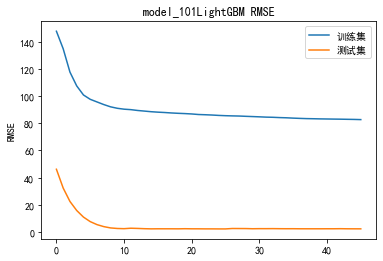

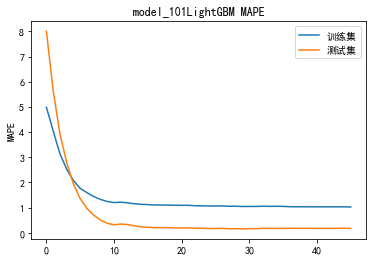

290392
*****Prediction for 销售区域: 102*****
[10]	training's rmse: 72.0655	training's mape: 1.17013	training's l2: 5193.43	valid_1's rmse: 2.2562	valid_1's mape: 0.352382	valid_1's l2: 5.09045
[20]	training's rmse: 68.1891	training's mape: 0.987221	training's l2: 4649.75	valid_1's rmse: 1.43572	valid_1's mape: 0.149891	valid_1's l2: 2.06128
[30]	training's rmse: 66.1133	training's mape: 0.962087	training's l2: 4370.96	valid_1's rmse: 1.45422	valid_1's mape: 0.154761	valid_1's l2: 2.11475
[40]	training's rmse: 64.7176	training's mape: 0.951177	training's l2: 4188.37	valid_1's rmse: 1.64564	valid_1's mape: 0.156492	valid_1's l2: 2.70813


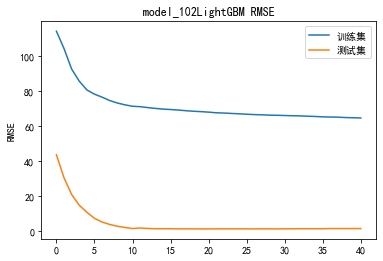

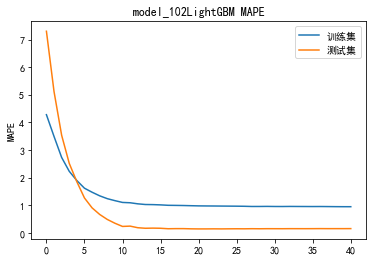

238041
*****Prediction for 销售区域: 103*****
[10]	training's rmse: 91.4801	training's mape: 1.25664	training's l2: 8368.61	valid_1's rmse: 2.80101	valid_1's mape: 0.227528	valid_1's l2: 7.84564
[20]	training's rmse: 87.3553	training's mape: 1.0973	training's l2: 7630.95	valid_1's rmse: 3.09585	valid_1's mape: 0.21442	valid_1's l2: 9.5843
[30]	training's rmse: 85.1945	training's mape: 1.06325	training's l2: 7258.1	valid_1's rmse: 3.5021	valid_1's mape: 0.221399	valid_1's l2: 12.2647


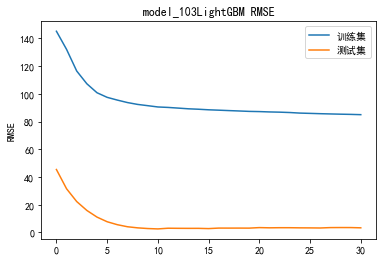

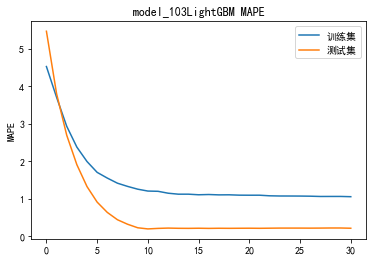

25053
*****Prediction for 销售区域: 104*****
303357
*****Prediction for 销售区域: 105*****
[10]	training's rmse: 87.7456	training's mape: 1.38746	training's l2: 7699.29	valid_1's rmse: 3.31191	valid_1's mape: 0.639971	valid_1's l2: 10.9687
[20]	training's rmse: 82.5457	training's mape: 1.17343	training's l2: 6813.8	valid_1's rmse: 2.51175	valid_1's mape: 0.427208	valid_1's l2: 6.30887
[30]	training's rmse: 79.9892	training's mape: 1.13651	training's l2: 6398.26	valid_1's rmse: 2.47568	valid_1's mape: 0.414886	valid_1's l2: 6.12899
[40]	training's rmse: 78.4104	training's mape: 1.1271	training's l2: 6148.19	valid_1's rmse: 2.5798	valid_1's mape: 0.416913	valid_1's l2: 6.65536


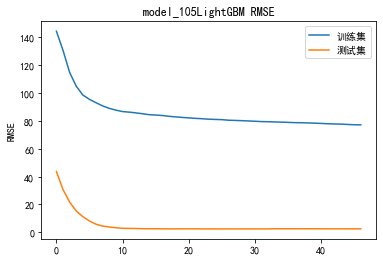

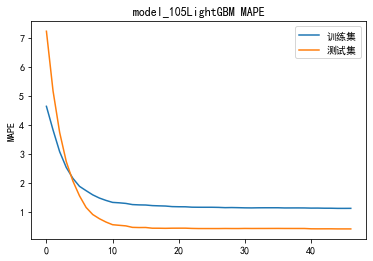

In [32]:
for store in states:
    try:
        df = data[data['销售区域编码']==store]
        print(len(df))

        #Split the data
        X_train, y_train = df[df['D']<1246].drop('订单需求量',axis=1), df[df['D']<1246]['订单需求量']
        X_valid, y_valid = df[(df['D']>=1246) & (df['D']<1278)].drop('订单需求量',axis=1), df[(df['D']>=1246) & (df['D']<1278)]['订单需求量']
        X_test = df[df['D']>=1278].drop('订单需求量',axis=1)

        #Train and validate
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
        print('*****Prediction for 销售区域: {}*****'.format(store))
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                 eval_metric='rmse,mape', verbose=10, early_stopping_rounds=20)
        valid_preds[X_valid.index] = model.predict(X_valid)
        eval_preds[X_test.index] = model.predict(X_test)
        filename = "models/" + "model_"+ str(store) + ".pkl"
        # save model
        joblib.dump(model, filename)
#         print("ces:",model.evals_result_)
        plot_logloss(model,"model_"+ str(store))
   
        del model, X_train, y_train, X_valid, y_valid
    except:
        del model, X_train, y_train, X_valid, y_valid
        continue

# 模型验证

In [33]:
model = joblib.load("models/model_102.pkl")
model

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=8,
              min_child_weight=300, n_estimators=1000, num_leaves=50,
              subsample=0.8)

In [34]:
df = data[data['销售区域编码']==102]
X_valid, y_valid = df[(df['D']>=1246) & (df['D']<1277)].drop('订单需求量',axis=1), df[(df['D']>=1246) & (df['D']<1277)]['订单需求量']
y_valid

791503    5.0
791506    6.0
791511    7.0
791512    7.0
791513    5.0
         ... 
137905    7.0
137913    7.0
137926    9.0
137930    7.0
137933    4.0
Name: 订单需求量, Length: 38874, dtype: float64

In [35]:
s = model.predict(X_valid)
s

array([6.24974053, 5.05313774, 7.08034951, ..., 6.54727621, 7.19459618,
       5.05313774])

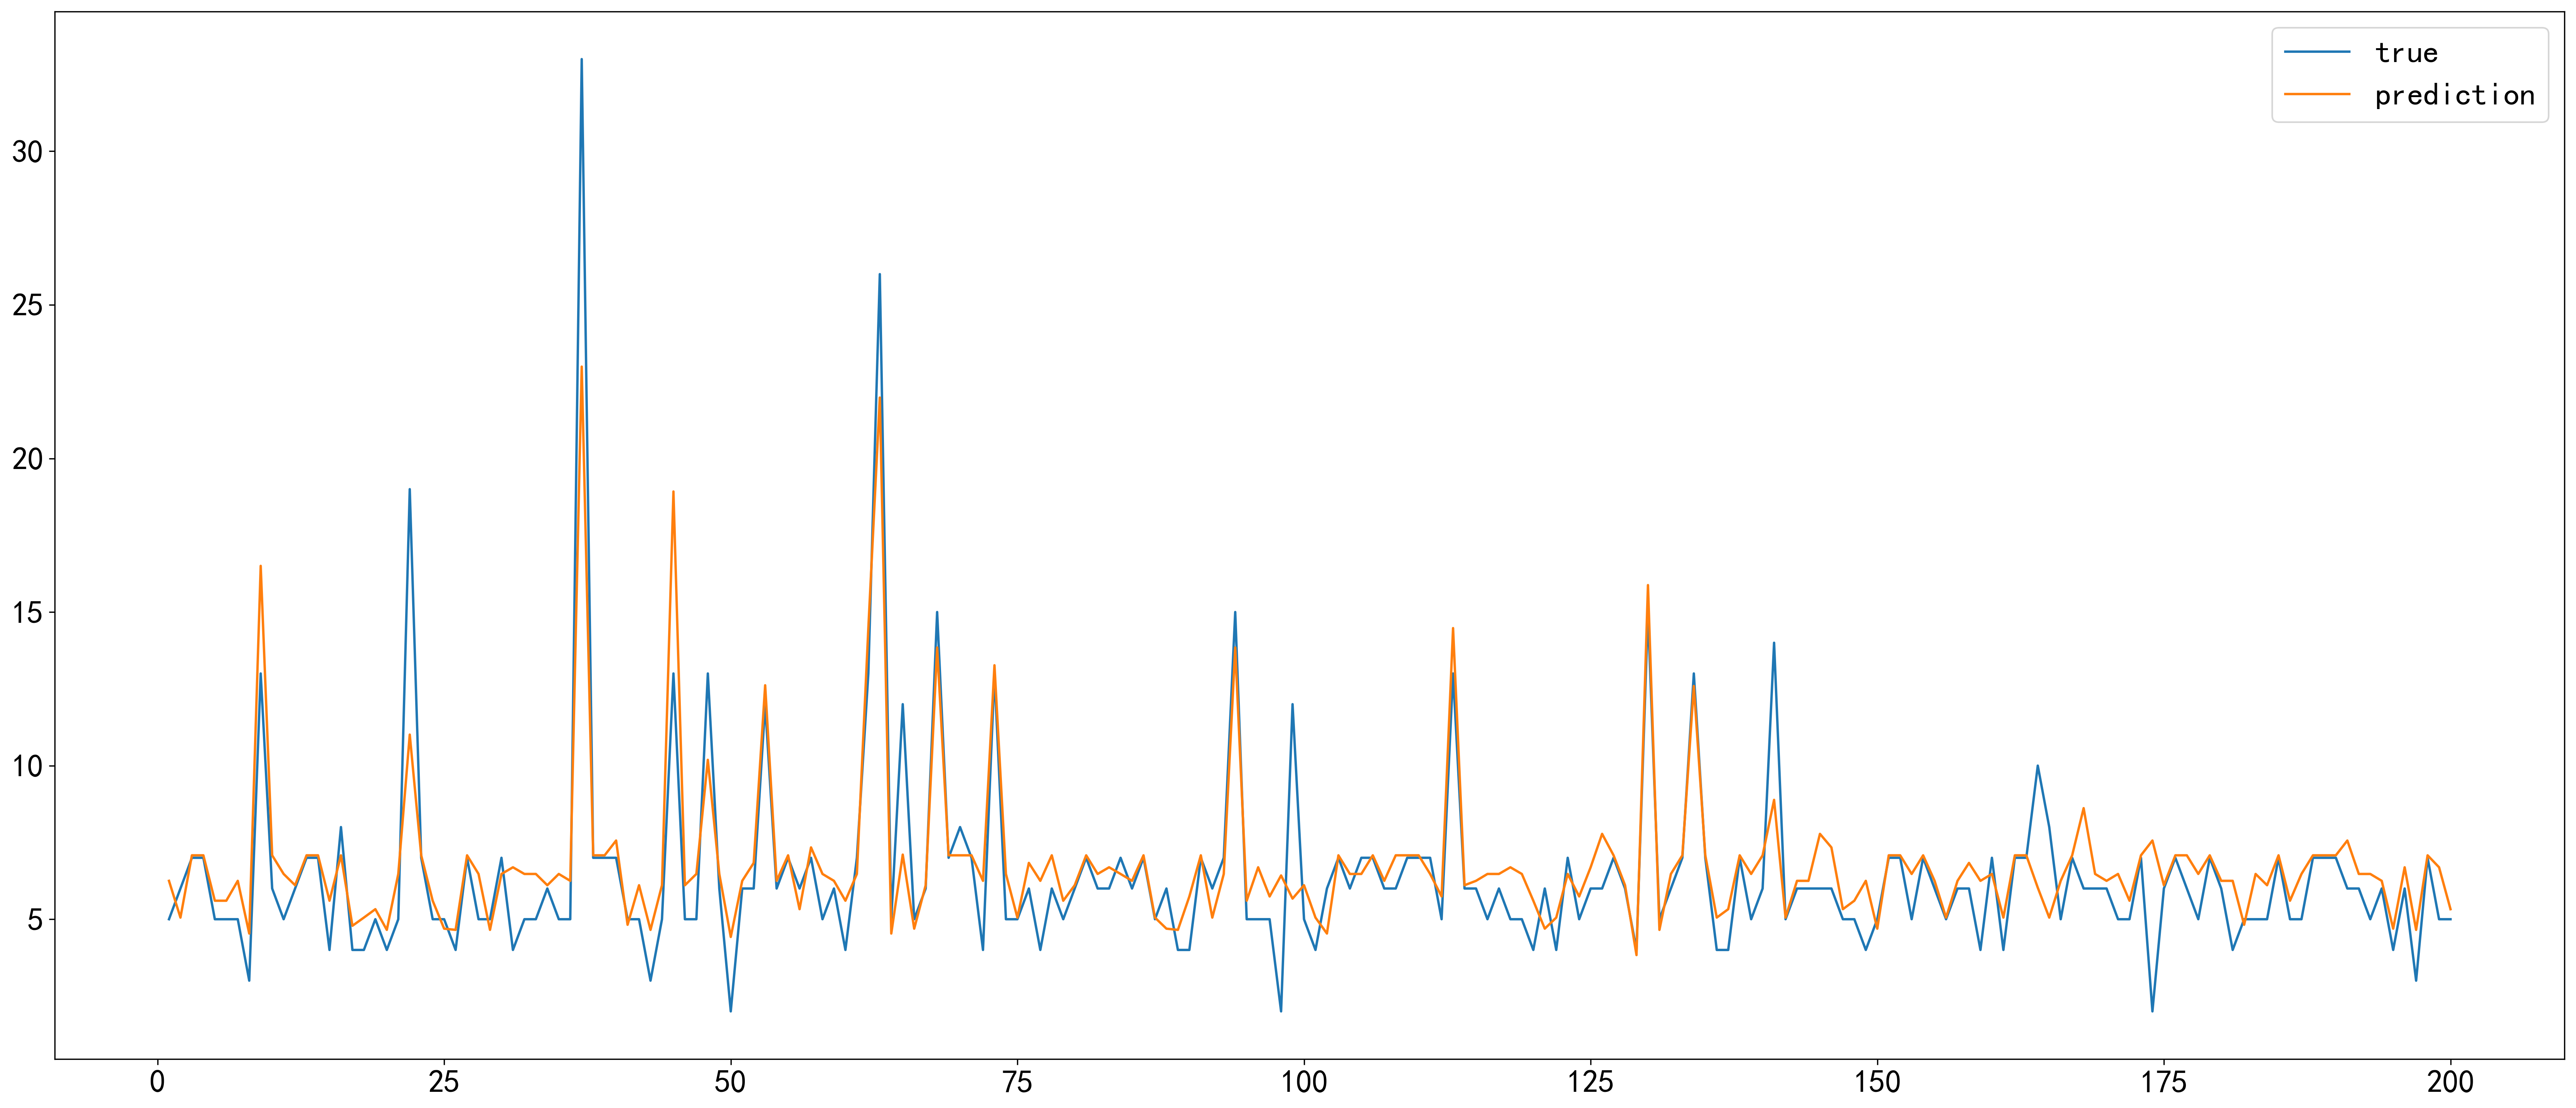

In [36]:
x_axis=np.linspace(1,len(y_valid),len(y_valid))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:200],y_valid[:200])
plt.plot(x_axis[:200],s[:200])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

# 预测样例数据结果

In [37]:
eval_preds  ##y预测出来19-03月的值

0         5.370515
1         6.087183
2         6.055577
3         6.040033
4         5.636342
            ...   
158374    9.016019
158375    7.915062
158376    6.233830
158377    6.073865
158378    1.606074
Name: 订单需求量, Length: 158379, dtype: float64

In [38]:
result=[]
for v in eval_preds:
    if v<0:
        result.append(0)  #预测值里有负值，这是不可能的，所有我们用0来代表异常值，产生这负数多半是因为训练时，对应产品的时间序列数据很少
    else:
        result.append(round(v,0))


In [39]:
## d读取之前构造好的19年3月数据：
df_sub= pd.read_csv('data/构造19_03data.csv')
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2019-03-01,101,20020,305,412,0,0,2019,3,1,0,1,1278,6,0,0,4,1
1,2019-03-01,101,20070,302,408,0,0,2019,3,1,0,1,1278,5,0,0,4,1
2,2019-03-01,105,20495,306,407,0,0,2019,3,1,0,1,1278,3,0,0,4,1
3,2019-03-01,101,20473,306,407,1,0,2019,3,1,0,1,1278,4,0,0,4,1
4,2019-03-01,105,20116,306,407,0,0,2019,3,1,0,1,1278,2,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,105,21424,306,407,0,0,2019,3,31,1,0,1308,1,2,0,6,0
158375,2019-03-31,102,21151,306,407,0,0,2019,3,31,1,0,1308,2,2,0,6,0
158376,2019-03-31,105,21070,303,401,1,0,2019,3,31,1,0,1308,4,2,0,6,0
158377,2019-03-31,101,22032,305,412,0,0,2019,3,31,1,0,1308,0,2,0,6,0


## 将预测的各产品19年三月需求量值进行替换

In [40]:
df_sub['订单需求量'] = result  #把预测的订单需求量替换
df_sub.to_csv('output/构造的3月数据预测结果.csv',index=False)
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2019-03-01,101,20020,305,412,0,5.0,2019,3,1,0,1,1278,6,0,0,4,1
1,2019-03-01,101,20070,302,408,0,6.0,2019,3,1,0,1,1278,5,0,0,4,1
2,2019-03-01,105,20495,306,407,0,6.0,2019,3,1,0,1,1278,3,0,0,4,1
3,2019-03-01,101,20473,306,407,1,6.0,2019,3,1,0,1,1278,4,0,0,4,1
4,2019-03-01,105,20116,306,407,0,6.0,2019,3,1,0,1,1278,2,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158374,2019-03-31,105,21424,306,407,0,9.0,2019,3,31,1,0,1308,1,2,0,6,0
158375,2019-03-31,102,21151,306,407,0,8.0,2019,3,31,1,0,1308,2,2,0,6,0
158376,2019-03-31,105,21070,303,401,1,6.0,2019,3,31,1,0,1308,4,2,0,6,0
158377,2019-03-31,101,22032,305,412,0,6.0,2019,3,31,1,0,1308,0,2,0,6,0


In [41]:
result_df = df_sub[['订单日期','销售区域编码','产品编码','产品大类编码','产品细类编码','订单需求量']]  #筛选出需要的列

result_df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量
0,2019-03-01,101,20020,305,412,5.0
1,2019-03-01,101,20070,302,408,6.0
2,2019-03-01,105,20495,306,407,6.0
3,2019-03-01,101,20473,306,407,6.0
4,2019-03-01,105,20116,306,407,6.0
...,...,...,...,...,...,...
158374,2019-03-31,105,21424,306,407,9.0
158375,2019-03-31,102,21151,306,407,8.0
158376,2019-03-31,105,21070,303,401,6.0
158377,2019-03-31,101,22032,305,412,6.0


## 制作透视表，计算各产品三月的总需求量

In [42]:
#制作透视表得到所有产品19年1月的需求量
result_df = pd.pivot_table(result_df, index=['销售区域编码','产品大类编码','产品细类编码','产品编码'], columns='订单日期',
                                  values='订单需求量', aggfunc=np.sum,fill_value=0).reset_index()
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31
0,101,301,405,20003,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1,101,301,405,20027,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,101,301,405,20085,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,101,301,405,20219,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5105,105,308,404,22005,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5106,105,308,404,22018,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5107,105,308,404,22023,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [43]:
result_df['3月总需求量'] = result_df.iloc[:,4:].sum(axis=1)  # 对0，1列按行求和，生成新列
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,3月总需求量
0,101,301,405,20003,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
1,101,301,405,20027,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
2,101,301,405,20085,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,155
3,101,301,405,20219,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
5105,105,308,404,22005,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,124
5106,105,308,404,22018,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
5107,105,308,404,22023,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,217


In [44]:
result_df = result_df[['销售区域编码','产品大类编码','产品细类编码','产品编码','3月总需求量']]
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,3月总需求量
0,101,301,405,20003,186
1,101,301,405,20027,186
2,101,301,405,20085,155
3,101,301,405,20219,186
4,101,301,405,20270,186
...,...,...,...,...,...
5104,105,308,404,21981,186
5105,105,308,404,22005,124
5106,105,308,404,22018,186
5107,105,308,404,22023,217


## 求每种产销售区域编码-品大类编码-产品细类编码的预测需求量的均值，作为新产品的预测值

In [45]:
new = result_df[['销售区域编码','产品大类编码','产品细类编码','3月总需求量']].groupby(['销售区域编码','产品大类编码','产品细类编码',]).mean().reset_index()
new

订单日期,销售区域编码,产品大类编码,产品细类编码,3月总需求量
0,101,301,405,183.416667
1,101,302,408,182.041825
2,101,303,401,181.623457
3,101,303,406,186.000000
4,101,303,410,186.000000
5,101,303,411,186.000000
6,101,304,409,186.125000
7,101,305,412,173.485207
8,101,306,402,301.214286
9,101,306,407,186.017588


## 读入predict_sku0.csv，进行匹配汇总，得到结果

In [46]:
# 读入predict_sku0.csv，进行匹配汇总，predict_sku0中的产品的3月需求量：
predict_df = pd.read_csv("../B题-全部数据//predict_sku1.csv")
predict_df.columns =['销售区域编码','产品编码','产品大类编码','产品细类编码',]
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
...,...,...,...,...
2614,105,22066,307,403
2615,105,22072,305,412
2616,105,22075,307,403
2617,105,22083,303,401


In [47]:
s=pd.merge(predict_df,result_df,how='left')


s 

,销售区域编码,产品编码,产品大类编码,产品细类编码,3月总需求量
0,101,20002,303,406,186.0
1,101,20003,301,405,186.0
2,101,20006,307,403,186.0
3,101,20011,303,401,NaN
4,101,20014,307,403,93.0
...,...,...,...,...,...
2614,105,22066,307,403,217.0
2615,105,22072,305,412,186.0
2616,105,22075,307,403,NaN
2617,105,22083,303,401,341.0


## 将新产品以预测同类型的产品的均值填充

In [48]:
xuqiu = []
for index,row in s.iterrows():
    if np.isnan(row['3月总需求量']):
#         print( row['1月总需求量'])
        
        t=int(new.loc[(new['销售区域编码']==row['销售区域编码'])&(new['产品大类编码']==row['产品大类编码'])&(new['产品细类编码']==row['产品细类编码'])]['3月总需求量'])
        xuqiu.append(t)
    else:
        xuqiu.append(int(row['3月总需求量']))
s['3月总需求量'] = xuqiu
s 

,销售区域编码,产品编码,产品大类编码,产品细类编码,3月总需求量
0,101,20002,303,406,186
1,101,20003,301,405,186
2,101,20006,307,403,186
3,101,20011,303,401,181
4,101,20014,307,403,93
...,...,...,...,...,...
2614,105,22066,307,403,217
2615,105,22072,305,412,186
2616,105,22075,307,403,227
2617,105,22083,303,401,341


In [56]:
s.to_csv('output/样本数据预测的3月predict_sku1.csv',index=False)